In [2]:
#calcular parâmetros das galáxias Usando flag como segmap
#EM CONSTRUÇÃO!
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from astropy.visualization import LogStretch
from matplotlib.colors import LogNorm
from astropy.modeling import models
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import photutils
import time
import statmorph


log_stretch = LogStretch(a=10000.0)

def normalize(image):
    m, M = np.min(image), np.max(image)
    return (image-m) / (M-m)

Filename: teste455.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (221, 221)   float32   


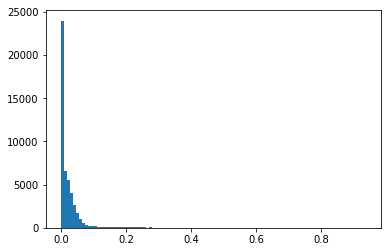

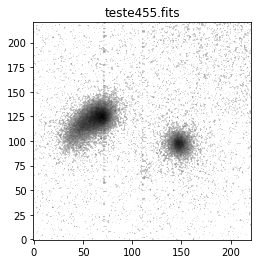

In [3]:
GHII = 'teste455.fits'
image_star = 'teste455_psf.fits'
simage_star = 'flag.fits'
weight = 'weight.fits'

filename = get_pkg_data_filename(GHII)
fits.info(filename)

galaxy = fits.open(filename)
#galaxy.writeto( 'newgalaxy.fits' ) #cria uma nova imagem fits. Pode ser usado após limpar o céu ou outra alteração. 
image_data = galaxy[0].data

NBINS = 100
histogram = plt.hist(image_data.flatten(), NBINS)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.title(filename)
plt.imshow(image_data, origin='lower', cmap='gray_r',norm=LogNorm(vmin=0.025, vmax=1))

[[ 0.00318465  0.00805727  0.0099864  ...  0.00929046 -0.00111046
  -0.00145137]
 [ 0.05221966  0.00099626 -0.02569547 ... -0.01403782  0.02457979
   0.01944867]
 [-0.00810513 -0.00318924 -0.05016769 ... -0.01662326  0.02777719
   0.02134237]
 ...
 [ 0.00167879  0.01616877 -0.01799586 ... -0.02358329 -0.02684981
  -0.01990187]
 [-0.02529204  0.01104283  0.00425363 ... -0.02600008  0.00571197
   0.01241431]
 [ 0.01415959 -0.01029727 -0.02906135 ... -0.02311102 -0.02014428
  -0.00047448]]


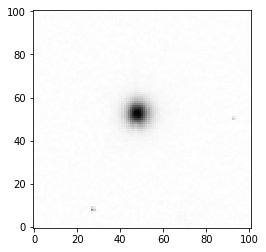

In [4]:
#Estrela PSF
psf = fits.open(image_star)
psf = psf[0].data
plt.imshow(psf, origin='lower', cmap='gray_r')
print(psf) #Matriz estrela

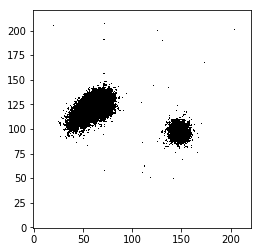

In [5]:
#Estrela segmap alternativo
seg = fits.open(simage_star)
segM = seg[0].data
plt.imshow(segM, origin='lower', cmap='gray')
print(seg) #Matriz estrela

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


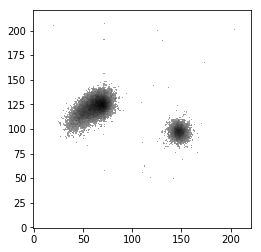

In [6]:
#mapa pixels - weight maps
m_pixel = fits.open(weight)
m_pixel = m_pixel[0].data
plt.imshow(m_pixel, origin='lower', cmap='gray_r', norm=LogNorm(vmin=0.025, vmax=1))
print(m_pixel) #Matriz mapa de pixel da galáxia

In [7]:
#convolução = Matriz de entrada e matriz de pesos
#image_data = ndi.convolve(image_data,weights=m_pixel, origin=[71,126]) #usando a origem ,origin=[204,204] da erro
#plt.imshow(image_data, origin='lower', cmap='gray_r')

In [8]:
#O SExtractor é indicado para fazer o mapa de segmentação. Segmap
#Porém estou usando photutils para fazer um.
threshold = photutils.detect_threshold(image_data, snr=1.5)
npixels = 5  # minimum number of connected pixels
segm = photutils.detect_sources(image_data, threshold, npixels)

[[1 1 1]
 [0 1 0]
 [0 0 1]]


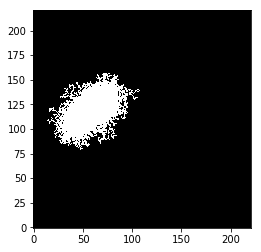

In [9]:
# Keep only the largest segment
label = np.argmax(segm.areas) + 1
segmap = segm.data == label
print(segm[0].data)
plt.imshow(segmap, origin='lower', cmap='gray')

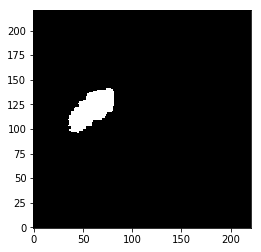

In [10]:
segmap_float = ndi.uniform_filter(np.float64(segmap), size=10)
segmap = segmap_float > 0.99
print(segmap[0].data)
plt.imshow(segmap, origin='lower', cmap='gray')

In [11]:
#Teste - segmap a partir do Flag.fit
threshold2 = photutils.detect_threshold(segM, snr=1.5)
npixels = 5  # minimum number of connected pixels
segMa = photutils.detect_sources(segM, threshold2, npixels)
labelM = np.argmax(segMa.areas)

ValueError: attempt to get argmax of an empty sequence

In [18]:

segMap = segMa.data == labelM
print(segMa[0].data)
plt.imshow(segMap, origin='lower', cmap='gray')

IndexError: list index out of range

In [ ]:
#---------------------------
segMap_float = ndi.uniform_filter(np.float64(segMap), size=10)
segMap = segMap_float < 0.01    #Invertido pq usamos o flag cujo zero é na região da galáxia
plt.imshow(segMap, origin='lower', cmap='gray')

In [10]:
#Agora que temos todos os dados necessários
Gain=1000.0 #Assumindo que existe uma média de mil elétrons / pixel no raio efetivo - gain=Gain
m_pixel #Ou Pode ser substituido(Gain) por uma matriz 2D weightmap=m_pixel, fornecida pelo SExtractor
start = time.time()
source_morphs = statmorph.source_morphology(image_data, seg, weightmap=m_pixel, psf=psf, eta=0.2)
print('Time: %g s.' % (time.time() - start))

/home/JackS/anaconda3/lib/python3.7/site-packages/statmorph/statmorph.py:1319: RuntimeWarning: divide by zero encountered in true_divide
  snp = np.mean(pixelvals / weightmap[locs])
/home/JackS/anaconda3/lib/python3.7/site-packages/statmorph/statmorph.py:1319: RuntimeWarning: invalid value encountered in true_divide
  snp = np.mean(pixelvals / weightmap[locs])


Finished processing source 1.

Time: 4.37604 s.


In [11]:
morph = source_morphs[0]
print('xc_centroid =', morph.xc_centroid)
print('yc_centroid =', morph.yc_centroid)
print('ellipticity_centroid =', morph.ellipticity_centroid)
print('elongation_centroid =', morph.elongation_centroid)
print('orientation_centroid =', morph.orientation_centroid)
print('xc_asymmetry =', morph.xc_asymmetry)
print('yc_asymmetry =', morph.yc_asymmetry)
print('ellipticity_asymmetry =', morph.ellipticity_asymmetry)
print('elongation_asymmetry =', morph.elongation_asymmetry)
print('orientation_asymmetry =', morph.orientation_asymmetry)
print('rpetro_circ =', morph.rpetro_circ)
print('rpetro_ellip =', morph.rpetro_ellip)
print('rhalf_circ =', morph.rhalf_circ)
print('rhalf_ellip =', morph.rhalf_ellip)
print('r20 =', morph.r20)
print('r50 =', morph.r50)
print('r80 =', morph.r80)
print('Gini =', morph.gini)
print('M20 =', morph.m20)
print('F(G, M20) =', morph.gini_m20_bulge)
print('S(G, M20) =', morph.gini_m20_merger)
print('sn_per_pixel =', morph.sn_per_pixel)
print('C =', morph.concentration)
print('A =', morph.asymmetry)
print('S =', morph.smoothness)
print('sersic_amplitude =', morph.sersic_amplitude)
print('sersic_rhalf =', morph.sersic_rhalf)
print('sersic_n =', morph.sersic_n)
print('sersic_xc =', morph.sersic_xc)
print('sersic_yc =', morph.sersic_yc)
print('sersic_ellip =', morph.sersic_ellip)
print('sersic_theta =', morph.sersic_theta)
print('sky_mean =', morph.sky_mean)
print('sky_median =', morph.sky_median)
print('sky_sigma =', morph.sky_sigma)
print('flag =', morph.flag)
print('flag_sersic =', morph.flag_sersic)
print('r50 em arcseg =',morph.r50*0.161)
print('Retorna o eixo semi-principal da elipse mínima =',morph.rmax_ellip)
print('O eixo semi-principal de uma abertura elíptica contendo 50% da luz =',morph.rhalf_ellip) 

xc_centroid = 76.07882922295177
yc_centroid = 118.147556813544
ellipticity_centroid = 0.7759032279711535
elongation_centroid = 4.462357895415274
orientation_centroid = -0.25645203825996965
xc_asymmetry = 61.728053219156735
yc_asymmetry = 121.76519593235125
ellipticity_asymmetry = 0.7949095466421796
elongation_asymmetry = 4.875897359567999
orientation_asymmetry = -0.25483696033020803
rpetro_circ = 39.61777960584345
rpetro_ellip = 156.69402377934782
rhalf_circ = 37.447086101736296
rhalf_ellip = 92.66323578948875
r20 = 8.840839155415457
r50 = 17.058974437189885
r80 = 34.41835578884139
Gini = 0.7268371557067228
M20 = -1.063642163287609
F(G, M20) = 0.37494793990659137
S(G, M20) = 0.24472252345267792
sn_per_pixel = -99.0
C = 2.951483151452803
A = 0.38137835970404
S = 0.05258683408634359
sersic_amplitude = 0.08379441126766103
sersic_rhalf = 92.66323578948875
sersic_n = 1.0
sersic_xc = 61.728053219156735
sersic_yc = 121.76519593235125
sersic_ellip = 0.7949095466421796
sersic_theta = 2.88675569

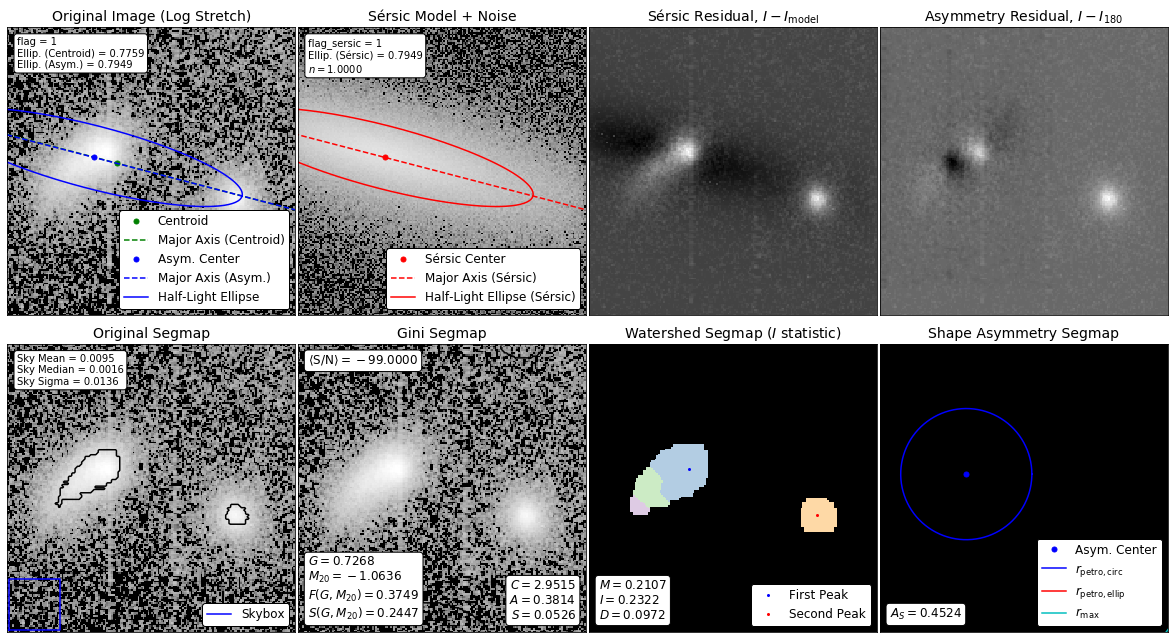

In [12]:
from statmorph.utils.image_diagnostics import make_figure
fig = make_figure(morph)
fig.savefig(GHII+'_morph.png', dpi=150)